In [35]:
#For Data Handling
import numpy as np
import pandas as pd

#For Modeling
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#For Modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout

#For plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For reading files from S3 
import s3fs
import io
import gzip


In [9]:
s3fs_obj= s3fs.S3FileSystem()
fs = s3fs.S3FileSystem()
final_df = pd.DataFrame()

df= pd.DataFrame()
aws_df = pd.DataFrame()
mini_df = pd.DataFrame()

In [10]:
#Reading Preprocessed Dataset
with fs.open('s3://c3-training-data/df_eda_aws.csv', 'rb') as f:
    decoded = gzip.GzipFile(fileobj=f)
    aws_df = pd.read_csv(decoded)

In [11]:
#Drop DateTime column as the data is already sorted, (Use the Commented code if data is not sorted and then drop this column)
#To sort columns
#aws_df.sort_values(by = 'bill/BillingPeriodStartDate')
aws_df = aws_df.drop(['bill/BillingPeriodStartDate', 'Unnamed: 0'], axis = 1)

In [12]:
aws_df.head(10)

,lineItem/UsageAccountId,lineItem/ProductCode,lineItem/BlendedCost,Credit,DiscountedUsage,Fee,RIFee,Refund,SavingsPlanCoveredUsage,SavingsPlanNegation,...,Tax,Usage,Anniversary,Purchase,Refund.1,AWS,AWS Marketplace,OnDemand,Reserved,Unknown
0,512106327079,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
1,512106327079,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
2,747531803056,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
3,747531803056,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
4,71580153059,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
5,71580153059,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
6,571230983818,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
7,571230983818,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
8,851677588718,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
9,851677588718,0.787641,0.84,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0


In [13]:
#Formatting the BlendedCost column to .5f precision
#The columns sometimes display values in exponential, which is hard to read

aws_df['lineItem/BlendedCost'] = aws_df['lineItem/BlendedCost'].apply(lambda x: '%.5f' %x)

In [14]:
#Displaying data to view columns
aws_df.head(10)

,lineItem/UsageAccountId,lineItem/ProductCode,lineItem/BlendedCost,Credit,DiscountedUsage,Fee,RIFee,Refund,SavingsPlanCoveredUsage,SavingsPlanNegation,...,Tax,Usage,Anniversary,Purchase,Refund.1,AWS,AWS Marketplace,OnDemand,Reserved,Unknown
0,512106327079,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
1,512106327079,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
2,747531803056,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
3,747531803056,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
4,71580153059,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
5,71580153059,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
6,571230983818,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
7,571230983818,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
8,851677588718,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
9,851677588718,0.787641,0.84000,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0


In [20]:
#Displaying the number of AccountIDs 

aws_df['lineItem/UsageAccountId'].nunique()

155

In [15]:
#Grouping by AccountID 
#Since we are predicting costs per UsageAccountID


aws_df_group = aws_df.groupby('lineItem/UsageAccountId')

In [44]:
#LSTM model Definition
#Try changing the hyperparameters - no.of units, dropout, metrics, optimizer, batch size, epochs - to improve accuracy
#batch_size — This is the number of windows of data we are passing at once.
#window_size — The number of days we consider to predict the bitcoin price for our case.
#hidden_layers — This is the number of units we use in our LSTM cell.
#clip_margin — This is to prevent exploding the gradient — we use clipper to clip gradients below above this margin.
#learning_rate — This is a an optimization method that aims to reduce the loss function.
#epochs — This is the number of iterations (forward and back propagation) our model needs to make.
#***CHANGE VALUES HERE IF PREDICTION IS BAD***

def create_model(X_train):
    #Initialising the RNN
    regressor = Sequential()
    
    #Adding the first LSTM layer and Dropout Regularization
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.5))
    
    #Adding a second LSTM layer and Dropout Regularization
    regressor.add(LSTM(units=30, return_sequences = True))
    regressor.add(Dropout(0.5))
    
    #Adding a third LSTM layer and Dropout Regularization
    regressor.add(LSTM(units = 25, return_sequences = True))
    regressor.add(Dropout(0.3))
    
    #Adding a fourth LSTM layer and Dropout Regularization
    regressor.add(LSTM(units = 20))
    regressor.add(Dropout(0.2))
    
    
    #Adding the output layer
    regressor.add(Dense(units=1))
    
    #Compiling the RNN
    regressor.compile(optimizer = 'adam', loss ='mean_squared_error', metrics = ['mse'])
    return regressor
    


In [ ]:
#Create a separate DataFrame and predict for each accountID group
#***DO NOT MAKE CHANGES ****
#Since we are predicting costs per UsageAccountID, now each UsageAccountID will have a dataset of their own, 
#Eg, 155 UsageAccountID will be mapped to 155 separate dataFrames, and each of them is trained separately, generates predictions for that UsageAccountID

for key, item in aws_df_group:
    #Creating a dataframe for every Account Group
    min_df = pd.DataFrame(aws_df_group.get_group(key))
    sc= MinMaxScaler()
    
    #Creating featureset for LSTM
    feature = min_df.drop(columns = ['lineItem/BlendedCost'])
    feature = sc.fit_transform(feature)
    
    #Setting prediction label as Blended Cost and reshaping it to fit LSTM
    label = min_df['lineItem/BlendedCost']
    label = label.values.reshape(-1,1)
    label = sc.fit_transform(label)
    
    #Splitting dataset - test - 25% , train - 75%
    X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = 0.25)
    
    #Reshaping the train and test set to fit LSTM
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    #Training LSTM
    model = create_model(X_train)
    model.fit(X_train, y_train, epochs = 25, batch_size =500, validation_split = 0.2)
    
    #Generating Predictions
    pred = model.predict(X_test)
    pred = sc.inverse_transform(pred)
    break

Train on 303744 samples, validate on 75936 samples
Epoch 1/25
303744/303744 [==============================] - 110s 361us/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 3.8525e-04 - val_mean_squared_error: 3.8525e-04
Epoch 2/25
303744/303744 [==============================] - 89s 294us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 4.9686e-04 - val_mean_squared_error: 4.9686e-04
Epoch 3/25
303744/303744 [==============================] - 89s 293us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 2.8635e-04 - val_mean_squared_error: 2.8635e-04
Epoch 4/25
303744/303744 [==============================] - 90s 297us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 2.1304e-04 - val_mean_squared_error: 2.1304e-04
Epoch 5/25
303744/303744 [==============================] - 89s 293us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 2.1152e-04 - val_mean_squared_error: 2.1152e-04
Epoch 6/25
167500/303744 [===============>...........

In [40]:
pred

array([[0.04435216],
       [0.04434835],
       [0.04434835],
       ...,
       [0.04434709],
       [0.04435342],
       [0.04434835]], dtype=float32)

TypeError: unhashable type: 'numpy.ndarray'

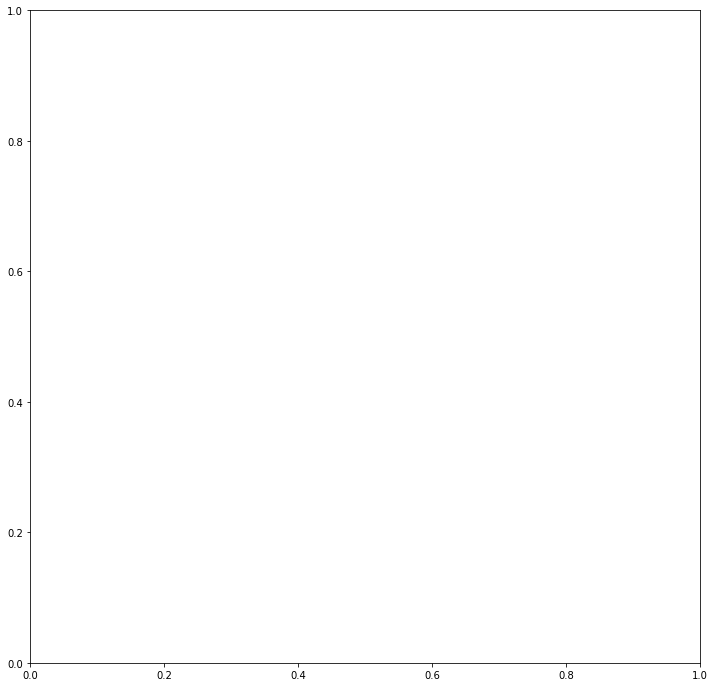

In [43]:
plt.figure(figsize = (12,12))
#plt.plot(sc.inverse_transform(y_test), color = 'green', label = 'Actual Values')
plt.plot(y_test, color = 'black', label = 'Actual Values')
plt.plot(pred, color = 'green', label = 'Predicted Values')
plt.title('Cloud Cost Prediction')
plt.xlabel('Time')
plt.ylabel('$')
plt.legend()
plt.show()